In [4]:
using LowRankModels
using PyPlot
using CSV
using ProgressMeter
using Statistics
using StatsBase
using LaTeXStrings
using Printf
using ScikitLearn.CrossValidation: KFold
using JLD2

# Load Henry coefficient matrix `H`

see `CreateMatrix.ipynb` for Python code that queries the NIST database for the adsorption data and fits Henry's law to the adsorption data to identify the Henry constant.

the gases run along the columns, the materials run along the rows, and the entries are the Henry coefficients identified from experimental adsorption data.

In [8]:
@load joinpath("data", "logH_matrix_materials_and_gases.jld2") H master_list_of_materials master_list_of_gases MSE
#H = deepcopy(new_H) # log(H)
materials = String.(deepcopy(master_list_of_materials)) # list of materials, order corresponding to rows in H
gases = String.(deepcopy(master_list_of_gases)) # list of gases, order corresponding to cols in H

nm, ng = size(H) #no. of materials and gases

@assert length(materials) == nm && length(gases) == ng

In [13]:
sum(ismissing.(H))/length(H)

0.9044608901223147

## sort rows, cols according to the number of observations
... and sort `materials` and `gases` accordingly!

In [14]:
function sort_rows_cols_acc_to_nb_obs!(H::Array{Union{Float64, Missing}, 2}, 
                                       materials::Array{String, 1}, 
                                       gases::Array{String, 1})
    # rows
    nb_obs = [sum(.! ismissing.(H[i, :])) for i = 1:nm]
    ids_reorder = sortperm(nb_obs, rev=true)
    H .= H[ids_reorder, :]
    materials .= materials[ids_reorder]

    # cols
    nb_obs = [sum(.! ismissing.(H[:, j])) for j = 1:ng]
    ids_reorder = sortperm(nb_obs, rev=true)
    H .= H[:, ids_reorder]
    gases .= gases[ids_reorder]

    # sanity check
    @assert sum(ismissing.(H[:, 1])) <= sum(ismissing.(H[:, 3])) # first row has fewer missing values
    @assert sum(ismissing.(H[1, :])) <= sum(ismissing.(H[3, :])) # first col has fewer missing values
    return nothing
end

sort_rows_cols_acc_to_nb_obs!(H, materials, gases)

## prune matrix by selecting rows/cols with the most observations

In [19]:
nm = 40
ng = 25

H = H[1:nm, 1:ng]
MSE = MSE[1:nm, 1:ng]
materials = materials[1:nm]
gases = gases[1:ng];

sort_rows_cols_acc_to_nb_obs!(H, materials, gases)
println("min # observations in a row: ", sum(.! ismissing.(H[end, :])))
println("min # observations in a col: ", sum(.! ismissing.(H[:, end])))
# TODO copy Arni's code for viz of frequency of observations gases and mofs

min # observations in a row: 4
min # observations in a col: 4


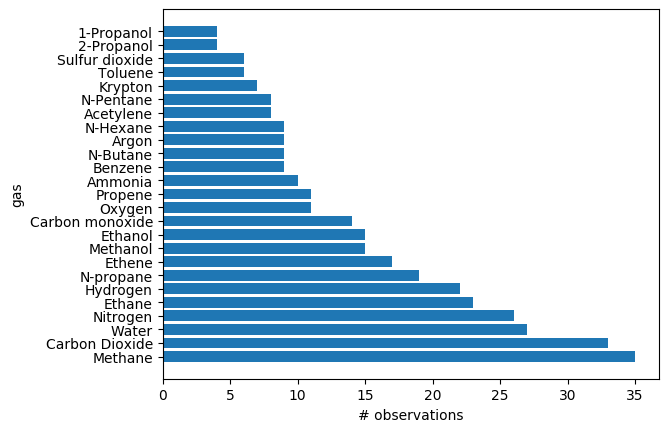

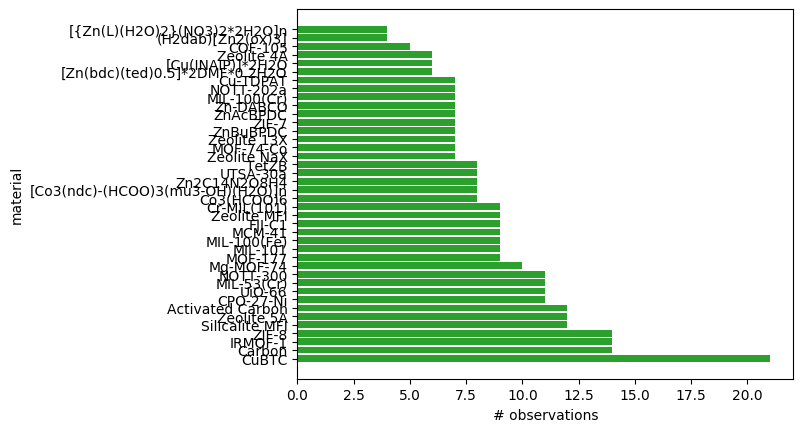

PyObject Text(24.000000000000043, 0.5, 'material')

In [20]:
plt.figure()
barh(gases, [sum(.! ismissing.(H[:, j])) for j = 1:ng])
xlabel("# observations")
ylabel("gas")

plt.figure()
barh(materials, [sum(.! ismissing.(H[i, :])) for i = 1:nm], color="C2")
xlabel("# observations")
ylabel("material")

## standardize columns
* standardize the columns (representing $H$'s for a certain gas) so that each column has mean zero and variance of one

In [21]:
# standardize the columns
for j = 1:ng
    # find ids that are not missing
    ids = .! ismissing.(H[:, j])
    # Hij <-- (Hij - μ_j) / σ_j 
    H[:, j] .= (H[:, j] .- mean(H[ids, j])) ./ std(H[ids, j])
end
# Udell ?: does it make sense to normalizes gases but not MOFs? 
#  Cory's justification: gases exhibit tons of variance in the means

In [22]:
H

40×25 Array{Union{Missing, Float64},2}:
  0.381152    0.126205    0.538225  …  -0.00339544    missing    missing
 -0.0406836  -0.384605   -1.11286        missing      missing    missing
 -0.181628   -0.598613   -1.89829      -0.933831      missing    missing
 -0.426021   -1.08031    -1.30589      -0.650778      missing    missing
  0.446767     missing   -1.47125        missing      missing    missing
  0.454759    2.01466     1.72659   …    missing      missing    missing
  0.547377   -0.0083425   0.700035       missing      missing    missing
  0.605807    1.34037     1.49395        missing      missing    missing
  0.0945577  -0.277977    0.267769       missing      missing    missing
 -1.53389    -0.726104   -1.21771        missing      missing    missing
 -0.645168    0.346065     missing  …   1.8741        missing    missing
  0.735302    1.59696     1.27537        missing      missing    missing
 -0.177095   -0.597106    1.30628      -0.418067      missing    missing
  ⋮        

## visualize

here, a diverging colormap is appropriate since the columns are standardized.

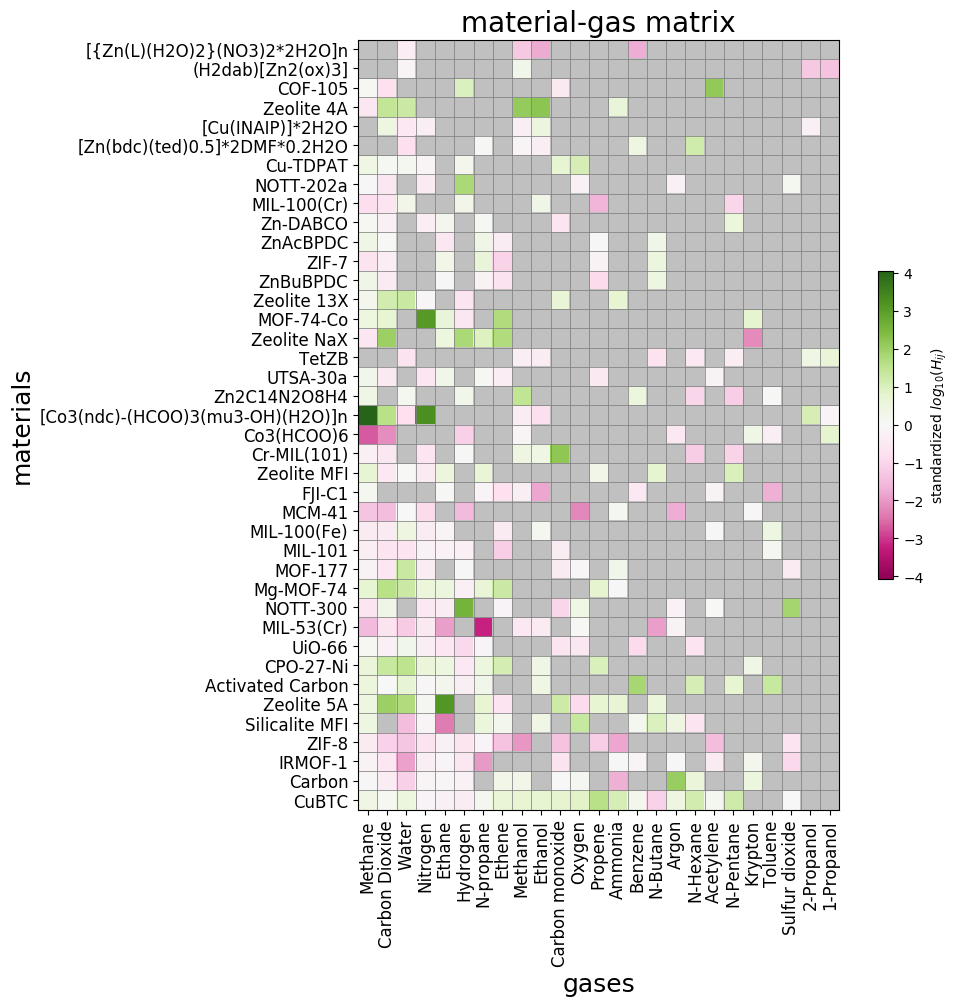

In [23]:
spy_H = deepcopy(H)
spy_H[ismissing.(H)] .= 0.0

spy_H2 = fill(0.0, size(H))
spy_H2[.!ismissing.(H)] .= 0
spy_H2[ismissing.(H)] .= 1

fig, ax = subplots(figsize=(10, 10))
img = ax.pcolormesh(spy_H, cmap="PiYG", 
    vmax=maximum(abs.(spy_H)), vmin=-maximum(abs.(spy_H)))
cbar = colorbar(img, label=L"standardized $log_{10}(H_{ij})$", shrink=0.4)

#cmap = plt.get_cmap("PiYG")
#colors = cmap(collect(1:cmap.N))
colors = Array{Float64, 2}(undef, 2, 4)
colors[1, :] .= [255.0, 255.0, 255.0, 0.0] ./ 255
colors[2, :] .= [192., 192., 192., 255.] ./ 255
cmap = matplotlib.colors.ListedColormap(colors)
img = ax.pcolormesh(spy_H2, cmap=cmap)

# grid lines
for x = 1:nm
    plot([0, ng], [x, x], linewidth=0.55, color="gray")
end
for y = 1:ng
    plot([y, y ], [0, nm], linewidth=0.55, color="gray")
end
ax.set_aspect("equal")
ax.set_title("material-gas matrix", fontsize=20)
ax.set_xlabel("gases", fontsize=18)
ax.set_ylabel("materials", fontsize=18)
# TODO make missing values black to distinguish between actual 0 and missing.
# TODO xticks, yticks with material and gas names
xticks(collect(1:ng) .- 0.5, gases, rotation=90, fontsize=12)
yticks(collect(1:nm) .- 0.5, materials, fontsize=12);
plt.savefig("prelim_H_matrix.png", dpi=300, format="png")

## work with `H'`, i.e. transpose of `H` to add row offsets via `LowRankModels.jl`

In [24]:
H = collect(H')

25×40 Array{Union{Missing, Float64},2}:
  0.381152    -0.0406836   -0.181628   …   0.121109    missing    missing
  0.126205    -0.384605    -0.598613      -0.768743    missing    missing
  0.538225    -1.11286     -1.89829         missing  -0.126598  -0.369422
 -0.146232    -0.122871    -0.328633        missing    missing    missing
 -0.230185    -0.0740213   -0.144518        missing    missing    missing
 -0.398256    -0.221314    -0.553376   …   1.00137     missing    missing
  0.141282      missing    -1.9894          missing    missing    missing
  0.696303     0.297204      missing        missing    missing    missing
  0.787966     0.288531      missing        missing   0.273844  -1.26438 
  0.758835      missing      missing        missing    missing  -1.74907 
  0.797667    -0.00974785  -0.724182   …  -0.479644    missing    missing
  0.911748     0.188096      missing        missing    missing    missing
  1.58761       missing      missing        missing    missing    missin

# find the optimal low rank model through cross-validation

In [25]:
ids_obs = observations(H) # returns tuple of observations
nb_obs = length(ids_obs)
println("# observations = ", nb_obs)
println("fraction entries that are filled = ", nb_obs / nm / ng)

# observations = 357
fraction entries that are filled = 0.35700000000000004


### set up generalized low rank model for practice

we'll train on all data for practice to see how it works.

TODO: ask Prof. Udell why offsets are not regularized.

In [26]:
# k = rank of matrix
# γ = regularization param
# Udell: do we need to look at ch? does it tell us if it fails?
function fit_glrm(k::Int, γ::Float64, obs::Array{Tuple{Int64,Int64},1}; verbose::Bool=true)
    rg = QuadReg(γ) # quadratic regularizer on X, Y
    rm = QuadReg(γ * ng / nm)

    glrm = GLRM(H, QuadLoss(), rg, rm, k, obs=obs, offset=true)

    G, M, ch = fit!(glrm, ProxGradParams(max_iter=1000), verbose=verbose) # H' ~ G' * M well, our mathy H

    @assert isapprox(impute(glrm), G' * M)
    return G, M, glrm, ch
end

G, M, glrm, ch = fit_glrm(1, 30.0, ids_obs)

Fitting GLRM
Iteration 10: objective value = 211.87890913854994


([1.0 1.0 … 1.0 1.0], [0.43637988249648874 0.02055455372104933 … -0.6129704853274375 -1.2700673133544262], GLRM(Union{Missing, Float64}[0.38115185297140847 -0.0406836070763114 … missing missing; 0.12620524027370253 -0.38460549111992454 … missing missing; … ; missing missing … -1.2465978697032392 missing; missing missing … -1.3687255634859237 missing], Loss[QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain())  …  QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain())], Regularizer[lastentry1(QuadReg(30.0)), lastentry1(QuadReg

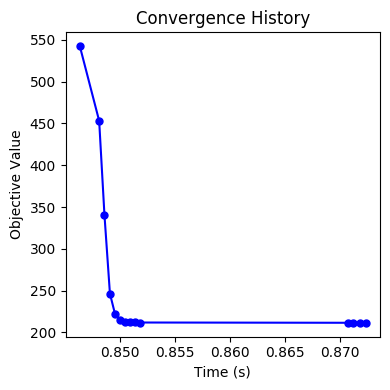

In [27]:
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(ch.times, ch.objective, color="b", marker="o", markersize=5)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Objective Value")
ax.set_title("Convergence History")
plt.tight_layout()
plt.show()

### split the observations into `n_folds` folds.

TODO: ask Prof. Udell how this works when a MOF is missing from a row.

In [28]:
function k_fold_split(H::Array{Union{Missing, Float64}, 2}, k::Int; max_iter=1000)
    #@assert k > 1 "Choose a `k` greater than 1, otherwise this function is pointless"
    @printf("Splitting matrix into %d folds\n", k)

    fold_matrix = fill(0, size(H))
    all_k_folds_not_represented_in_each_column = true
    n_iteration = 0

    while all_k_folds_not_represented_in_each_column
        n_iteration += 1
        all_k_folds_not_represented_in_each_column = false
        for j_col = 1:size(H)[2]
            # Grabs all available indices in row `i_row`
            i_indices = findall(.!ismissing.(H[:,j_col]))
            # As long as there are enough data points to distribute between `k` folds, we'll equally distribute them.
            while length(i_indices) >= k
                for fold = 1:k
                    i = rand(1:length(i_indices))
                    fold_matrix[i_indices[i], j_col] = fold
                    deleteat!(i_indices, i)
                end
            end
            # If there are leftover data points (i.e. #data points left < `k`), we'll randomly assign them into folds
            for i in i_indices
                #items = collect(1:k)
                #weights = [sum(fold_matrix[:, j_col] .!= _k .| fold_matrix[:, j_col] .!= 0) for _k = 1:k]
                #fold_matrix[i, j_col] = sample(items, Weights(weights))
                fold_matrix[i, j_col] = rand(1:k)
            end
        end
        # We make sure we have enough data points in the columns as well
        for i_row = 1:size(H)[1]
            unique_folds = unique(fold_matrix[i_row, :])
            if length(unique_folds) <= k
                all_k_folds_not_represented_in_each_column = true
                break
            end
        end

        # If too many iteration are performed an Exception is raised.
        if n_iteration >= max_iter
            error("Maximum number of iterations reached. Try changing the `max_iter` argument.")
        end
    end
    
    for i = 1:size(H)[1]
        for j = 1:size(H)[2]
            if ismissing(H[i,j])
                continue
            else
                @assert fold_matrix[i,j] != -1 "A non-NaN value was not put in a fold"
            end
        end
    end
    
    @printf("Number of iterations required to split data into %d-folds: %d\n", k, n_iteration)
    for fold = 1:k
        @printf("Number of data points in fold %d: %d\n", fold, sum(fold_matrix .== fold))
    end
    @printf("Total number of data points: %d\n", sum(.!ismissing.(H)))
    @printf("-----------------------------------\n")
    return fold_matrix
end

fold_matrix = k_fold_split(H, 3, max_iter=100000)
temp_fold_matrix = replace(fold_matrix, 0 => missing)
kfolds = [(findall(collect(skipmissing(temp_fold_matrix))[:] .!= k), 
           findall(collect(skipmissing(temp_fold_matrix))[:] .== k)) 
                for k = 1:length(unique(fold_matrix))-1]
n_folds = length(kfolds)

Splitting matrix into 3 folds
Number of iterations required to split data into 3-folds: 9
Number of data points in fold 1: 122
Number of data points in fold 2: 117
Number of data points in fold 3: 118
Total number of data points: 357
-----------------------------------


3

In [29]:
#n_folds = nb_obs # K-fold cross validation
#println("running $n_folds-cross validation...")
#kfolds = KFold(nb_obs, n_folds=n_folds, shuffle=true);

visualize the fold matrix

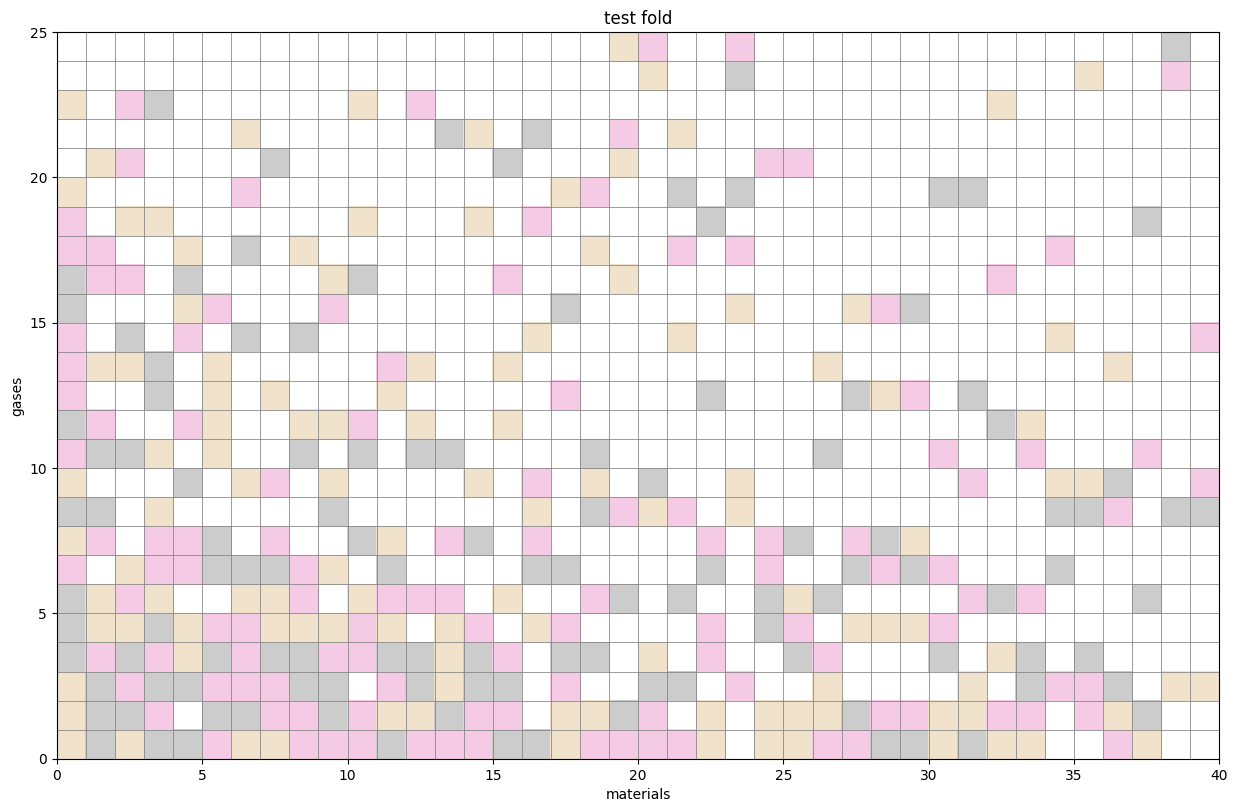

In [34]:
test_fold_matrix = Int.(zeros(size(H)))
for (i, fold) in enumerate(kfolds)
    for ix in fold[2]
        test_fold_matrix[ids_obs[ix][1], ids_obs[ix][2]] = i
    end
end

cmap = plt.get_cmap("Pastel2")
colors = cmap(collect(1:cmap.N))
#colors = Array{Float64, 2}(undef, 6, 4)
colors[1, :] .= [0.0, 0.0, 0.0, 0.0] ./ 255
# colors[2, :] .= [128., 0., 0., 255.] ./ 255
# colors[3, :] .= [170., 255., 195., 255.] ./ 255
# colors[4, :] .= [145., 30., 180., 255.] ./ 255
# colors[5, :] .= [255., 250., 200., 255.] ./ 255
# colors[6, :] .= [0., 130., 200., 255.] ./ 255
cmap = matplotlib.colors.ListedColormap(colors)



fig, ax = plt.subplots(figsize=(15, 15))
ax.pcolormesh(test_fold_matrix, cmap=cmap)

# grid lines
for x = 1:size(test_fold_matrix)[1]
    plot([0, size(test_fold_matrix)[2]], [x, x], linewidth=0.55, color="gray")
end
for y = 1:size(test_fold_matrix)[2]
    plot([y, y ], [0, size(test_fold_matrix)[1]], linewidth=0.55, color="gray")
end


ax.set_aspect("equal")
ax.set_xlabel("materials")
ax.set_ylabel("gases")
ax.set_title("test fold")
#ax.set_xlabel("Fold Frequency")
# TODO put legend in there for the fold
plt.savefig("prelim_fold_matrix.png", dpi=300, format="png")
plt.show()

## run cross-validation

specify the range of ranks and regularization params we aim to cover

In [31]:
ks = [1,2,3] # ranks
γs = 10.0 .^ range(0.0, 5.0, length=6); # regularization params

map rank to color for data visualizations

In [32]:
cmap = PyPlot.matplotlib.cm.viridis
norm = PyPlot.matplotlib.colors.Normalize(vmin=minimum(ks), vmax=maximum(ks))
rank_to_color = PyPlot.matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap).to_rgba

PyObject <bound method ScalarMappable.to_rgba of <matplotlib.cm.ScalarMappable object at 0x7f270d6b5588>>

run `n_folds` cross validation, store test error for each $(k, \gamma)$ combo

In [33]:
# TODO ask Prof. Udell if it makes any sense to regularize X, Y separately

# progress meter
p = Progress(n_folds * length(ks) * length(γs))

mse = Dict(k => zeros(length(γs)) for k in ks) # store MSE for each regularization param and k

# loop over ranks
for (i_k, k) in enumerate(ks)
    # loop over regularization params
    for (i_γ, γ) in enumerate(γs)
        # loop over folds
        for (train_ids, test_ids) in kfolds
            # train model on training data
            G, M, glrm, ch = fit_glrm(k, γ, ids_obs[train_ids], verbose=false)
            # assess error on test data
            Ĥ = impute(glrm)
            H_pred = [Ĥ[i, j] for (i, j) in ids_obs[test_ids]]
            H_actual = [H[i, j] for (i, j) in ids_obs[test_ids]]
            mse[k][i_γ] += sum((H_pred .- H_actual) .^ 2) / length(test_ids)
            ProgressMeter.next!(p)
        end
    end
    mse[k] /= n_folds
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


visualize average `n_fold` test set error against regularization param $\gamma$ for different ranks

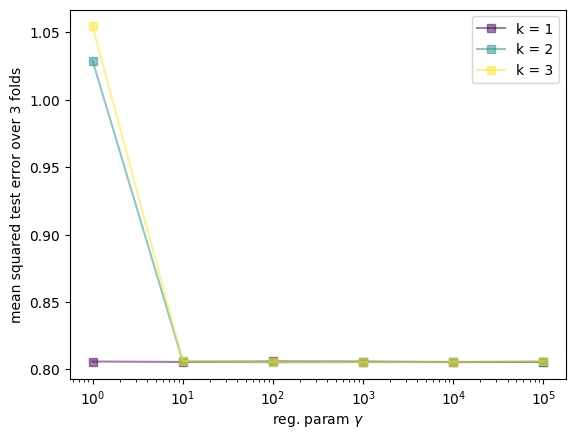

PyObject <matplotlib.legend.Legend object at 0x7f270fa3f9e8>

In [35]:
figure()
xlabel(L"reg. param $\gamma$")
ylabel("mean squared test error over $n_folds folds")
for k in ks
    plot(γs, mse[k], label=@sprintf("k = %d", k), marker="s", color=rank_to_color(k), alpha=0.5)
end
xscale("log")
legend()
# Udell ?: should call when we only have MOF offsets, k = 0 or k = 1?
# Udell ?: if we are not regularizing the offsets, why is k=1 fixed? do we need to change max_iter or something?

## work with optimal model

In [36]:
min_mse = [minimum(mse[k]) for k in ks]
opt_k = ks[argmin(min_mse)] # optimum rank
opt_γ = γs[argmin(mse[opt_k])]

@show(min_mse)
@printf("optimum γ = %.3f, optimum k = %d\n", opt_γ, opt_k)

min_mse = [0.8054097577378975, 0.8052618666952586, 0.8053476341659516]
optimum γ = 100.000, optimum k = 2


### parity plot over `n_folds`-cross validation

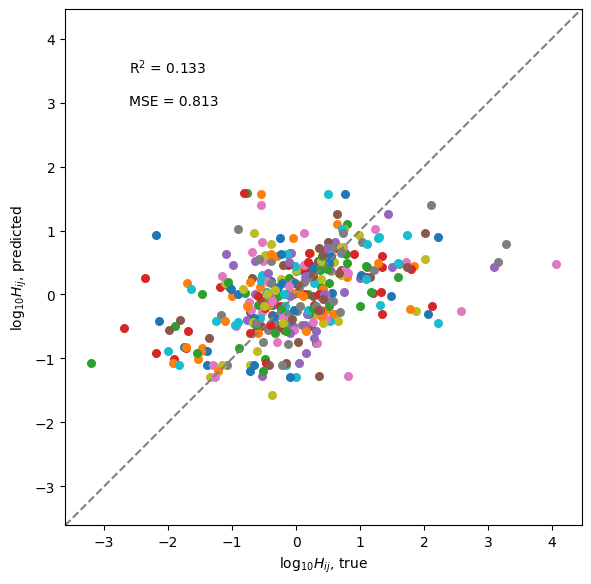

this_mse = 0.8132272982697012
R² = 0.13288414582086083
Numerator: 287.882
Denomirator: 332.000


In [54]:
H_actual = Float64[]
H_pred = Float64[]
this_mse = 0.0
langmuir_mse = Float64[]
for (train_ids, test_ids) in kfolds
    # train model on training data
    G, M, glrm, ch = fit_glrm(opt_k, opt_γ, ids_obs[train_ids], verbose=false)
    
    # test
    Ĥ = impute(glrm)
    @assert G' * M ≈ Ĥ
    H_pred = vcat(H_pred, [Ĥ[i, j] for (i, j) in ids_obs[test_ids]])
    H_actual = vcat(H_actual, [H[i, j] for (i, j) in ids_obs[test_ids]])
    this_mse = sum((H_pred .- H_actual) .^ 2) / length(test_ids)
    langmuir_mse = vcat(langmuir_mse, [MSE'[i,j] for (i, j) in ids_obs[test_ids]])
end

this_mse /= n_folds
@show(this_mse)

R² = 1 - sum((H_pred .- H_actual) .^ 2) / sum((H_actual .- mean(H_actual)) .^ 2)
@show R²
@printf("Numerator: %.3f\n", sum((H_pred .- H_actual) .^ 2))
@printf("Denomirator: %.3f\n", sum((H_actual .- mean(H_actual)) .^ 2))

cmap = plt.get_cmap("viridis")
#norm = PyPlot.matplotlib.colors.Normalize(vmin=minimum(skipmissing(langmuir_mse)), vmax=maximum(skipmissing(langmuir_mse)))
#rank_to_color = PyPlot.matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap).to_rgba


fig, ax = subplots(figsize=(6,6))
xlabel(L"$\log_{10} H_{ij}$, true")
ylabel(L"$\log_{10} H_{ij}$, predicted")
#hexbin(H_actual, H_pred, cmap="Greens", mincnt=1) #mincnt=1 makes bins white
for i in 1:length(H_actual)
    scatter(H_actual[i], H_pred[i], c=langmuir_mse[i], s=30, cmap=cmap, vmin=minimum(langmuir_mse), vmax=maximum(langmuir_mse))
end
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot(xlim, xlim, linestyle="--", color="gray")
ax.text(xlim[1]+1, xlim[2]-1, @sprintf("R\$^2\$ = %.3f",R²))
ax.text(xlim[1]+1, xlim[2]-1.5, @sprintf("MSE = %.3f",this_mse))
ax.set_xlim(xlim)
ax.set_ylim(xlim)
ax.set_aspect("equal")
plt.tight_layout()
plt.savefig("prelim_results.png", dpi=300, format="png")

In [ ]:
function gas_parity_plot(gas::Union{Int, AbstractString})
    if typeof(gas) <: AbstractString
        @assert gas in gases
        gas = findfirst(gas .== gases)
    end
    H_actual = Array{Float64, 1}()
    H_pred = Array{Float64, 1}()
    rmses = Array{Float64, 1}()
    for (train_ids, test_ids) in kfolds
        # train model on training data
        G, M, glrm, ch = fit_glrm(opt_k, opt_γ, ids_obs[train_ids], verbose=false)

        # test
        Ĥ = impute(glrm)
        H_pred = vcat(H_pred, [Ĥ[i, j] for (i, j) in ids_obs[test_ids] if i == gas])
        H_actual = vcat(H_actual, [H[i, j] for (i, j) in ids_obs[test_ids] if i == gas])
    end
    mses = (H_pred .- H_actual) .^2 ./ length(H_pred)
    this_mse = sum(mses)

    R² = 1 - sum((H_pred .- H_actual) .^ 2) / sum((H_actual .- mean(H_actual)) .^ 2)
    #@show R²
    #@printf("Numerator: %.3f\n", sum((H_pred .- H_actual) .^ 2))
    #@printf("Denomirator: %.3f\n", sum((H_actual .- mean(H_actual)) .^ 2))
    spearman = corspearman(H_actual, H_pred)
    #@show spearman

    fig, ax = subplots(figsize=(10,10))
    ax.set_xlabel(L"$\log_{10} H_{ij}$, true")
    ax.set_ylabel(L"$\log_{10} H_{ij}$, predicted")
    if length(H_pred) > 800
        ax.hexbin(H_actual, H_pred, cmap="Greens", mincnt=1) #mincnt=1 makes bins white
    else
        ax.scatter(H_actual, H_pred, s=30, fc="#469990", ec="k", alpha=0.8)
    end
    xlim = [ax.get_xlim()...]
    ylim = [ax.get_ylim()...]
    
    lim = diff(xlim)[1] > diff(ylim)[1] ? xlim : ylim
    ax.plot(lim.*1.1, lim.*1.1, linestyle="--", color="gray")
    ax.set_xlim(lim.*1.1)
    ax.set_ylim(lim.*1.1)
    ax.text(lim[1]+0.1, lim[2]-0.2, @sprintf("R\$^2\$ = %.3f\nMSE = %.3f\nSpearman = %.3f", R², sum((H_pred .- H_actual) .^ 2)/length(H_pred), spearman))

    ax.set_title("Parity plot for " * gases[gas])
    ax.set_aspect("equal")
end
gas_parity_plot.(1:5)

## viz offsets and latent space on fully trained model

In [ ]:
G, M, glrm, ch = fit_glrm(opt_k, opt_γ, ids_obs, verbose=false)

### offsets $\mu_i$ representing material biases

In [ ]:
μ = M[end, :]

figure()
bar(1:nm, μ[sortperm(μ)])
xlabel("material")
ylabel(L"offset $\mu_i$")
xticks(1:nm, materials[sortperm(μ)], rotation=90);

In [ ]:
function plot_offset(μ::Array{Float64, 1}, show_all_materials=false)
    N = length(μ)
    sorted_idx = sortperm(μ)[end:-1:1]
    color = "#469990"
    edgecolor = "k"
    if N > 40 && !show_all_materials
        fig, ax = plt.subplots(figsize=(20,8))
        ax.bar(1:19, μ[sorted_idx][1:19], 0.8, linewidth=1.5, label="Offset", color=color, edgecolor=edgecolor)
        ax.bar(21:40, μ[sorted_idx][end-19:end], 0.8, linewidth=1.5, label="Offset", color=color, edgecolor=edgecolor)
        ax.plot([-1, 19.7], [0, 0], c=edgecolor, lw=2.5)
        ax.plot([20.3, 41], [0, 0], c=edgecolor, lw=2.5)
        ax.plot([19.7, 19.9], [0, 0.5], c=edgecolor, lw=2.5)
        ax.plot([19.9, 20.1], [0.5, -0.5], c=edgecolor, lw=2.5)
        ax.plot([20.1, 20.3], [-0.5, 0], c=edgecolor, lw=2.5)
        ax.set_xlim(0, 41)
    else
        fig, ax = plt.subplots(figsize=(20,8))
        ax.bar(1:N, μ[sorted_idx], 0.8, linewidth=1.5, label="Offset", color=color, edgecolor=edgecolor)
        xlim = ax.get_xlim()
        ax.plot(xlim, [0, 0], c=edgecolor, lw=3.5, alpha=0.5)
        ax.set_xlim(0, N)
    end
    
    
    ax.set_ylabel(L"Material offset $\mathbf{\mu}$", fontsize=16)
    xlabels = [material for material in materials[sorted_idx]]
    if N > 40 && !show_all_materials
        ax.set_xticks(1:41)
            ax.set_xticklabels(vcat(vcat(xlabels[1:19], ["..."]), xlabels[end-19:end]), rotation=90, fontsize=16)
        for tick in ax.get_xticklabels()
            if tick.get_text() == "..."
                tick.set_rotation(0)
            end
        end
    else
        ax.set_xticks(1:length(xlabels))
        ax.set_xticklabels(xlabels, rotation=90, fontsize=16)
    end
    #ax.set_title(mof_or_gas + ' biases from RecSys model', fontsize=16)
    plt.tight_layout()
    plt.savefig("prelim_offset.png", dpi=300, format="png")
    plt.show()
end
asdf = plot_offset(μ, false)

### latent space of materials